<a href="https://colab.research.google.com/github/SIRIUS-webkit/face_mask_detection_deep_learning/blob/main/face_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/SIRIUS-webkit/face_mask_detection_deep_learning.git

Cloning into 'face_mask_detection_deep_learning'...
remote: Enumerating objects: 3746, done.
remote: Counting objects: 100% (3746/3746), done.
remote: Compressing objects: 100% (3741/3741), done.
remote: Total 3746 (delta 0), reused 3732 (delta 0), pack-reused 0
Receiving objects: 100% (3746/3746), 121.88 MiB | 32.70 MiB/s, done.


In [2]:
import os
import cv2
import numpy as np

In [3]:
data = []
label = []
base_path = "/content/face_mask_detection_deep_learning/dataset"
for category in os.listdir(base_path):
  img_path = os.path.join(base_path, category)
  for images in os.listdir(img_path):
    real_img = os.path.join(img_path, images)
    img = cv2.imread(real_img)
    resized = cv2.resize(img, (112,112))
    data.append(resized)
    label.append(category)
data = np.array(data)/255.0
label = np.array(label)

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
label = lb.fit_transform(label)
label = to_categorical(label)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [6]:
x_train,x_test,y_train,y_test = train_test_split(data,label,test_size=0.20,random_state=42)
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [7]:
numClasses = 2
batch_size = 32

model = Sequential()

#first layer
model.add(Conv2D(200,(3,3), input_shape=(112,112,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(50, activation="relu"))
model.add(Dense(numClasses, activation="softmax"))

print(model.summary)


<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f1e32071390>>


In [8]:
EPOCHS = 30
opt = Adam(lr=0.0001, decay=0.0001 / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
H = model.fit(
	aug.flow(x_train, y_train, batch_size=32),
	steps_per_epoch=len(x_train) // 32,
	validation_data=(x_test, y_test),
	validation_steps=len(x_test) // 32,
	epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
95/95 [==============================] - 43s 113ms/step - loss: 0.4779 - accuracy: 0.7805 - val_loss: 0.2770 - val_accuracy: 0.9016
Epoch 2/30
95/95 [==============================] - 11s 111ms/step - loss: 0.3262 - accuracy: 0.8763 - val_loss: 0.2218 - val_accuracy: 0.9173
Epoch 3/30
95/95 [==============================] - 10s 108ms/step - loss: 0.3053 - accuracy: 0.8806 - val_loss: 0.2180 - val_accuracy: 0.9226
Epoch 4/30
95/95 [==============================] - 11s 112ms/step - loss: 0.2878 - accuracy: 0.8909 - val_loss: 0.2021 - val_accuracy: 0.9226
Epoch 5/30
95/95 [==============================] - 10s 105ms/step - loss: 0.2765 - accuracy: 0.8886 - val_loss: 0.2111 - val_accuracy: 0.9213
Epoch 6/30
95/95 [==============================] - 10s 102ms/step - loss: 0.2654 - accuracy: 0.8969 - val_loss: 0.1804 - val_accuracy: 0.9331
Epoch 7/30
95/95 [==============================] - 10s 103ms/step - loss: 0.2533 - accuracy: 0.9019 - val_loss: 0.1776 - val_accuracy: 0.9318

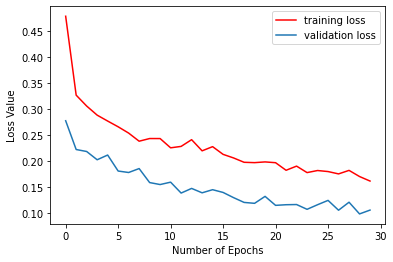

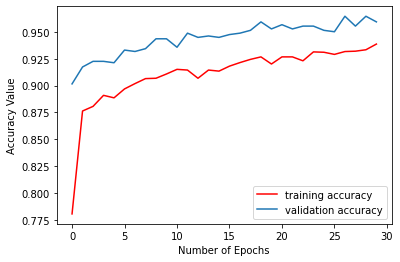

In [9]:
from matplotlib import pyplot as plt
plt.plot(H.history['loss'], 'r', label='training loss')
plt.plot(H.history['val_loss'], label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

plt.plot(H.history['accuracy'], 'r', label='training accuracy')
plt.plot(H.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()


In [10]:
predict = model.predict(x_test)

In [11]:
result = model.evaluate(x_test,y_test)
print(result)

24/24 [==============================] - 0s 16ms/step - loss: 0.1054 - accuracy: 0.9593
[0.10536111891269684, 0.9593175649642944]


In [12]:
model.save('face_mask_detector_modelv1.h5')